## Imports


### Imports  library for this project

In [96]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.preprocessing import OneHotEncoder

### Connecting the drive to to notebook by running this code.

In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Collection and Processing


### Data Collection




```
import cv2
import os
import time

def capture_images_from_esp32(class_name, esp32_url, capture_duration=20, save_dir='/home/harsh/Desktop/Task2/new_data'):
    # Create the directory for the class if it doesn't exist
    class_dir = os.path.join(save_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    # Start capturing images from ESP32-CAM
    cap = cv2.VideoCapture(esp32_url)
    if not cap.isOpened():
        print(f"Failed to open video stream at {esp32_url}")
        return

    start_time = time.time()
    img_count = 0

    while int(time.time() - start_time) < capture_duration:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture image from ESP32-CAM")
            break

        # Save the frame as an image file
        img_path = os.path.join(class_dir, f"{img_count}.jpg")
        cv2.imwrite(img_path, frame)
        img_count += 1

        # Display the frame (optional)
        cv2.imshow('Capturing', frame)

        # Press 'q' to quit early
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the capture and close any OpenCV windows
    cap.release()
    cv2.destroyAllWindows()
    print(f"Captured {img_count} images for class '{class_name}'.")

if __name__ == "__main__":
    esp32_url = 'http://192.168.144.123:81/stream'  # Replace with your ESP32-CAM stream URL
    print(f"Trying to open video stream at {esp32_url}")

    while True:
        class_name = input("Which class are you going to capture? (leave empty to exit) ")
        if not class_name:
            print("Exiting...")
            break

        print(f"Starting capture for class: {class_name}")
        capture_images_from_esp32(class_name, esp32_url)
        print(f"Finished capturing images for class: {class_name}")

```



### Storing collected data into a csv file

In [98]:
from PIL import Image
from sklearn.model_selection import train_test_split


# this code for store the collected data into a csv file
def image_to_csv(image_folder_path, train_csv_file_path, test_csv_file_path, test_size=0.2, random_state=42):
    rows = []
    labels = [folder for folder in os.listdir(image_folder_path) if os.path.isdir(os.path.join(image_folder_path, folder))]

    for label in labels:
        label_folder_path = os.path.join(image_folder_path, label)

        for image_name in os.listdir(label_folder_path):
            if image_name.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_path = os.path.join(label_folder_path, image_name)
                image = Image.open(image_path)
                image = image.convert('L')
                image = image.resize((320, 240))  # Resize images to 320x240
                image_array = np.array(image)
                image_flattened = image_array.flatten().tolist()
                row = [label] + image_flattened
                rows.append(row)

    df = pd.DataFrame(rows)
    column_names = ['label'] + ['pixel_' + str(i) for i in range(len(rows[0]) - 1)]
    df.columns = column_names
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df['label'])
    train_df.to_csv(train_csv_file_path, index=False)
    test_df.to_csv(test_csv_file_path, index=False)

image_folder_path = '/content/drive/MyDrive/Last_Task/dataset'
train_csv_file_path = 'train.csv'
test_csv_file_path = 'test.csv'
image_to_csv(image_folder_path, train_csv_file_path, test_csv_file_path)


### Data Loading


Now reading our created csv file from the drive, replace this with your address of csv file.

In [99]:
train_df = pd.read_csv("/content/drive/MyDrive/Last_Task/data/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Last_Task/data/test.csv")

In [100]:
test = pd.read_csv("/content/drive/MyDrive/Last_Task/data/test.csv")
y = test['label']

Function which converts the labels into a integer like:


*   a ---> 1
*   b ---> 2
*   c ---> 3

and so on...



In [101]:
def change_label(row):
    label = row['label']
    # Determine weather condition
    if label == 'a':
        change = 1 # a
    elif label == 'b':
        change = 2 # b
    elif label == 'c':
        change = 3 # c
    elif label == 'd':
        change = 4 # d
    elif label == 'empty':
        change = 0 # empty

    return change

Now we have to apply the functions previously made to convert the labels from string to an integer value which will be helpful for our model development.

In [102]:
# Apply the function to each row of the DataFrame
train_df['label'] = train_df.apply(change_label, axis=1)
test_df['label'] = test_df.apply(change_label, axis=1)

Now defining y_train and y_test for developing our model as labels

In [103]:
y_train = train_df['label']
y_test = test_df['label']
y_debug = y_train[0:10]
del train_df['label']
del test_df['label']

In [104]:
print(y_train) # Prints the y_train all labels

0      1
1      4
2      0
3      1
4      2
      ..
441    3
442    0
443    0
444    3
445    0
Name: label, Length: 446, dtype: int64


In [105]:
train_df.shape # prints the shape of the train_df

(446, 1600)

The code snippet provided utilizes the LabelBinarizer class from the sklearn.preprocessing module in the scikit-learn library. This class is used to convert categorical labels into a binary (one-hot encoded) format

In [106]:
from sklearn.preprocessing import LabelBinarizer # Import the LabelBinarizer

In [107]:
label_binarizer = LabelBinarizer() # Create an instance of LabelBinarizer

In [108]:
# Fit on the training data and transform both train and test data
y_train = label_binarizer.fit_transform(y_train) # Fit the LabelBinarizer on the y_train data and transform it
y_test = label_binarizer.fit_transform(y_test) # Fit the LabelBinarizer on the y_test data and transform it

Now defining the x_train and x_test for development of our model.

In [109]:
x_train = train_df.values
x_test = test_df.values

In [110]:
# Convert y_train and y_test to numpy arrays if they are pandas Series
if isinstance(y_train, pd.Series):
    y_train = y_train.to_numpy()
if isinstance(y_test, pd.Series):
    y_test = y_test.to_numpy()

In [111]:
# One-hot encode the labels
encoder = OneHotEncoder(sparse=False)

In [112]:
# Reshape y_train and y_test for encoding
y_train_flat = y_train.reshape(-1, 1)
y_test_flat = y_test.reshape(-1, 1)

y_train_encoded = encoder.fit_transform(y_train_flat)
y_test_encoded = encoder.transform(y_test_flat)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [113]:
# Reshape x_train and x_test to 4D tensors if they are not already
if len(x_train.shape) == 2:  # If the shape is (num_samples, height*width)
    x_train = x_train.reshape(x_train.shape[0], 40, 40, 1)
if len(x_test.shape) == 2:  # If the shape is (num_samples, height*width)
    x_test = x_test.reshape(x_test.shape[0], 40, 40, 1)

In [114]:
# This code will print the shape of all the data for developing the model
print("Shape of y_train_encoded:", y_train_encoded.shape)
print("Shape of y_test_encoded:", y_test_encoded.shape)
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of y_train_encoded: (2230, 2)
Shape of y_test_encoded: (560, 2)
Shape of x_train: (446, 40, 40, 1)
Shape of x_test: (112, 40, 40, 1)


In [115]:
# Reshaping the array if not in desired shape
print("Shape of x_train:", x_train.shape)
try:
    reshaped_array = x_train.reshape(-1, 40, 40, 1)
    print("Shape of the reshaped array:", reshaped_array.shape)
except ValueError as e:
    print("Error:", e)

Shape of x_train: (446, 40, 40, 1)
Shape of the reshaped array: (446, 40, 40, 1)


### Debugging the data before model development.

In [116]:
x_tmp = x_train[0]
x_tmp=x_tmp.reshape(1,40,40,1)
x_tmp = np.array(x_tmp)
x_tmp.shape

(1, 40, 40, 1)

In [117]:
np.transpose(y_debug).shape

(10,)

In [118]:
# I will use this for debuggin on the ESP32
x_debug = (train_df.values)[0:10]
csv_x_debug = 'csv_x.csv'
csv_y_debug = 'csv_y.csv'
y_db2 = np.array(y_debug).reshape(1,-1)
# Write data to the CSV file
np.savetxt(csv_x_debug, x_debug, delimiter=',', fmt='%s')
np.savetxt(csv_y_debug, y_db2, delimiter=',', fmt='%s')

### Some more data processing before model development

In [119]:
# Normalize the data
x_train = (x_train  / 127.5) - 1.0
x_test = (x_test/127.5)-1.0# - 128 # / 255

In [120]:
print(x_train.shape)
print(x_train.size)

(446, 40, 40, 1)
713600


In [121]:
print(x_test.shape)
print(x_test.size)

(112, 40, 40, 1)
179200


In [122]:
x_train = x_train.reshape(-1, 40, 40, 1)
x_test = x_test.reshape(-1, 40, 40, 1)

In [123]:
x_train.shape

(446, 40, 40, 1)

### Preview of our data

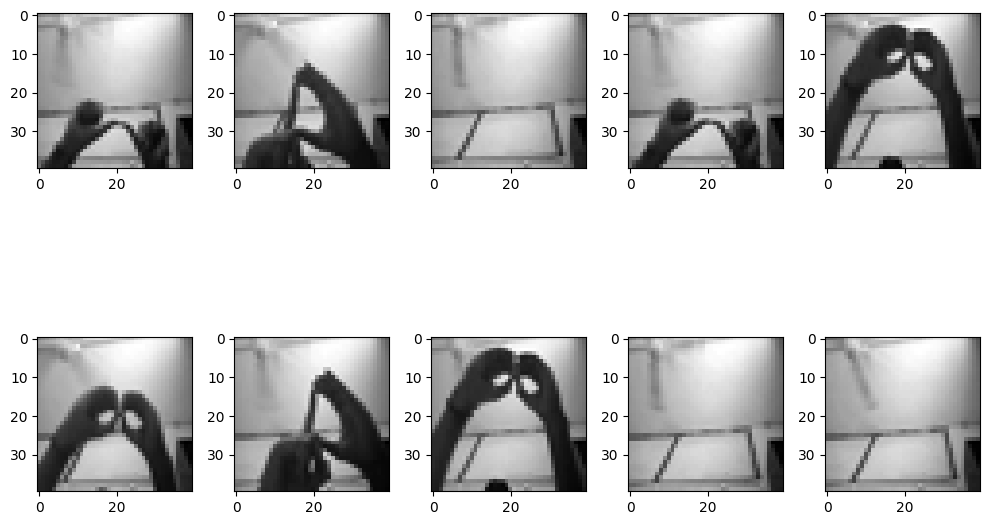

In [124]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(40, 40) , cmap = "gray")
        k += 1
    plt.tight_layout()

In [125]:
x_train.shape

(446, 40, 40, 1)

In [126]:
y_train.shape

(446, 5)

## Model Development

### Model Development

In [127]:
# Define your model
model = Sequential([
    Conv2D(65, kernel_size=(3, 3), activation='relu', input_shape=(40, 40, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(40, kernel_size=(3, 3), activation='relu'),
    Dropout(0.25),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(25, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # for 5 classes
])

In [128]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [129]:
# Print model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 38, 38, 65)        650       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 19, 19, 65)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 17, 17, 40)        23440     
                                                                 
 dropout_2 (Dropout)         (None, 17, 17, 40)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 40)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 25)         

In [130]:
y_train.shape

(446, 5)

In [131]:
# Initialize ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

This will slightly reduce the learning_rate_while developing the ML model for increasing the accuracy.

In [132]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [133]:
# Now fitting the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                    steps_per_epoch=len(x_train) / 128,
                    epochs=20,
                    validation_data=(x_test, y_test),
                    callbacks=[learning_rate_reduction])

Epoch 1/20
3/3 [==============================] - 2s 120ms/step - loss: 1.5380 - accuracy: 0.2803 - val_loss: 1.4256 - val_accuracy: 0.6607 - lr: 0.0010
Epoch 2/20
3/3 [==============================] - 0s 60ms/step - loss: 1.3144 - accuracy: 0.5897 - val_loss: 1.0589 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/20
3/3 [==============================] - 0s 88ms/step - loss: 0.8886 - accuracy: 0.7803 - val_loss: 0.5608 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 4/20
3/3 [==============================] - 0s 105ms/step - loss: 0.5625 - accuracy: 0.8632 - val_loss: 0.2658 - val_accuracy: 0.9732 - lr: 0.0010
Epoch 5/20
3/3 [==============================] - 0s 98ms/step - loss: 0.4198 - accuracy: 0.8722 - val_loss: 0.1567 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 6/20
3/3 [==============================] - 0s 112ms/step - loss: 0.3657 - accuracy: 0.9036 - val_loss: 0.0851 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 7/20
3/3 [==============================] - 0s 109ms/step - loss: 0.2662 - accu

### Model evaluation

In [134]:
# Evaluate the model
accuracy = model.evaluate(x_test, y_test)[1]
print("Accuracy of the model is - {:.2f}%".format(accuracy * 100))

4/4 [==============================] - 0s 4ms/step - loss: 0.0181 - accuracy: 1.0000
Accuracy of the model is - 100.00%


This will generate a Training & Validation Accuracy and a Testing Accuracy & Loss graph for visualising the accuracy as per epochs to check for over fitting.

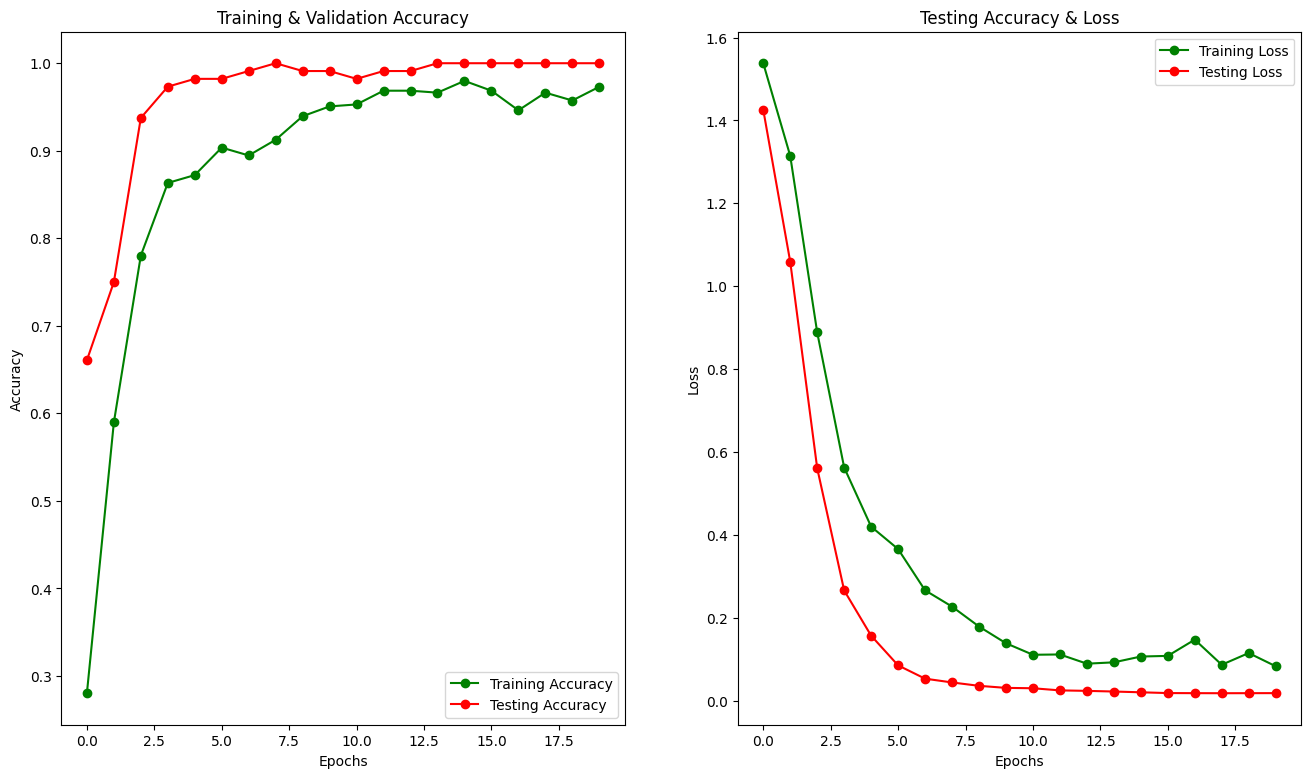

In [135]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [136]:
# Predicting the first five test data
preds = model.predict(x_test)
predictions = np.argmax(preds, axis=1)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]

4/4 [==============================] - 0s 3ms/step


array([0, 3, 0, 2, 1])

Now model is saved for our further use

In [137]:
# Save the model
model.save('sign_language_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Converting o tensorflow lite model.

In [138]:
import tensorflow.compat.v1 as tf
# x_test_flat=tf.cast(tf.squeeze(x_test, axis=-1), tf.float32) / 255.0
x_test_flat=tf.cast(x_test, tf.float32)# / 255.0
print(x_test_flat.shape)
xtest_ds = tf.data.Dataset.from_tensor_slices((x_test_flat)).batch(1)

(112, 40, 40, 1)


In [139]:
print(xtest_ds)
def representative_data_gen():
    for input_value in xtest_ds.take(100):
        yield [input_value]

<_BatchDataset element_spec=TensorSpec(shape=(None, 40, 40, 1), dtype=tf.float32, name=None)>


In [140]:
def representative_dataset():
    xtest_rd = test_df.values
    for i in range(250):
        nxt = (xtest_rd[i])
        nxt = nxt.reshape(1,100,100,1)
        nxt = np.array(nxt)
        nxt = ((nxt/127.5)-1.0).astype(np.float32)
        yield([nxt])

This code snippet will convert the tensorflow model to tflite model and save it

In [141]:
import tensorflow as tf # importing the tensorflow

In [142]:
# Create a TFLiteConverter object from the Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [143]:
# Define the representative dataset function if needed
def representative_dataset():
    for data in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [tf.dtypes.cast(data, tf.float32)]

In [144]:
# Optionally, set the representative dataset for quantization
converter.representative_dataset = representative_dataset

In [145]:
# Convert the model to the TFLite format
tflite_model = converter.convert()

In [146]:
# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

### Some useful function to calculate compare the size of our ml model.

In [147]:
# This will get the file size
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [148]:
# This will convert the size in bytes to KB and MB
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

### Converting to tflite

In [149]:
TF_LITE_MODEL_FILE_NAME = "ISL_lite.tflite"

In [150]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

In [151]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME

In [152]:
open("ISL_lite.tflite", "wb").write(tflite_model)

373204

In [153]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

File size: 364.457 Kilobytes


In [154]:
tflite_file_size = get_file_size(TF_LITE_MODEL_FILE_NAME)

## Quantization

### Quantization of tflite model

In [155]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 40 40  1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 5]
Output Type: <class 'numpy.float32'>


In [156]:
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 40, 40, 3)) # Add a dimension for channels
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [10000    40    40     3]
Input Type: <class 'numpy.float32'>
Output Shape: [10000     5]
Output Type: <class 'numpy.float32'>


In [157]:
x_test.dtype

dtype('float64')

In [158]:
x_test_numpy = np.array(x_test, dtype=np.float32)

In [159]:
x_test_numpy.dtype

dtype('float32')

In [160]:
tflite_model_path = "ISL_lite.tflite"

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']
print(input_shape)
print(output_shape)

[ 1 40 40  1]
[1 5]


In [161]:
nin = 600
nstrt = 1500

In [162]:
interpreter.resize_tensor_input(input_details[0]['index'], (nin, 40, 40,1))
interpreter.resize_tensor_input(output_details[0]['index'], (nin, 24))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [600  40  40   1]
Input Type: <class 'numpy.float32'>
Output Shape: [600   5]
Output Type: <class 'numpy.float32'>


In [163]:
import numpy as np

# Create a placeholder for your input data. Replace this with your actual input data.
input_data_float32 = np.random.rand(2000, 40, 40, 1).astype(np.float32) # Example: random data

# Convert input data from float32 to int8 and reshape if necessary
input_data_int8 = (input_data_float32[nstrt:(nstrt+nin), :, :, :] * 127.5).astype(np.int8)

# Print the new shapes and types
print("Input Shape:", input_data_int8.shape)
print("Input Type:", type(input_data_int8))

Input Shape: (500, 40, 40, 1)
Input Type: <class 'numpy.ndarray'>


In [164]:
x_test.shape

(112, 40, 40, 1)

In [165]:
nin = 32
nstrt = 0

In [166]:
# Get the actual number of samples in your test data
num_samples = x_test_numpy.shape[0]

# Resize the input tensor to match the number of samples in your test data
interpreter.resize_tensor_input(input_details[0]['index'], (num_samples, 40, 40, 1))
interpreter.allocate_tensors()

# Now set the tensor with your data
interpreter.set_tensor(input_details[0]['index'], x_test_numpy)
interpreter.invoke()


In [167]:
from time import time

# Scale the images and convert to float32
test_imgs_numpy = np.array(x_test[nstrt:(nstrt+nin), :, :, :] * 127.5, dtype=np.float32)

# Set the input tensor with the float32 data
t1 = time()
interpreter.set_tensor(input_details[0]['index'], x_test_numpy)  # Now the data type matches
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print((time()-t1)/nin)
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

0.0013592392206192017
Prediction results shape: (112, 5)


In [168]:
from sklearn.metrics import accuracy_score

# Calculate accuracy using prediction_classes and y_test
# Use the entire y_test array instead of slicing it
acc = accuracy_score(prediction_classes, np.argmax(y_test, axis=1))

# Print the test accuracy
print('Test accuracy TFLITE model:', acc*100, "%")

Test accuracy TFLITE model: 100.0 %


In [169]:
TF_LITE_MODEL_FLOAT_16_FILE_NAME = "tf_lite_float_16_model.tflite"

In [170]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_converter.target_spec.supported_types = [tf.float16]
tflite_model = tf_lite_converter.convert()

In [171]:
tflite_model_name = TF_LITE_MODEL_FLOAT_16_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

190144

In [172]:
convert_bytes(get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME), "KB")

File size: 185.688 Kilobytes


In [173]:
tflite_float_16_file_size = get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME)

In [174]:
TF_LITE_SIZE_QUANT_MODEL_FILE_NAME = "tf_lite_quant_model.tflite"

In [175]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = tf_lite_converter.convert()

In [176]:
tflite_model_name = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

100312

In [177]:
convert_bytes(get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME), "KB")

File size: 97.961 Kilobytes


In [178]:
tflite_float_quant_file_size = get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)

In [179]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 40 40  1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 5]
Output Type: <class 'numpy.float32'>


In [180]:
# Correctly resize the input tensor, keeping the batch dimension
interpreter.resize_tensor_input(input_details[0]['index'], (1, 40, 40, 1))  # Assuming 1 channel as before

# Allocate tensors after resizing
interpreter.allocate_tensors()

# Get the input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 40 40  1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 5]
Output Type: <class 'numpy.float32'>


In [181]:
x_test.dtype

dtype('float64')

In [182]:
test_imgs_numpy = np.array(x_test, dtype=np.float32)

In [183]:
test_imgs_numpy.dtype

dtype('float32')

In [184]:
# Get the actual number of samples in your test data
num_samples = test_imgs_numpy.shape[0]

# Resize the input tensor to match the number of samples in your test data
interpreter.resize_tensor_input(input_details[0]['index'], (num_samples, 40, 40, 1))
interpreter.allocate_tensors()

# Now set the tensor with your data
interpreter.set_tensor(input_details[0]['index'], x_test_numpy)
interpreter.invoke()


In [185]:
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (112, 5)


In [186]:
acc = accuracy_score(prediction_classes, np.argmax(y_test, axis=1))

In [187]:
print('Test accuracy TFLITE Quantized model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE Quantized model is 100.0%


## Deployment




```
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Read the image file
image_path = "/content/drive/MyDrive/Project/Indian Sign Language/data/d/D10.jpg"
image_data = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image_data, channels=1)

# Resize and normalize the image
image = tf.image.resize(image, [40, 40])
image = tf.cast(image, tf.float32) / 127.5 - 1.0

# Add a batch dimension
image = tf.expand_dims(image, axis=0)

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], image)

# Run the interpreter
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Get the predicted class
predicted_class = np.argmax(output_data)

if predicted_class == 1:
    predicted_gesture = "A"
elif predicted_class == 2:
    predicted_gesture = "B"
elif predicted_class == 3:
    predicted_gesture = "C"
elif predicted_class == 4:
    predicted_gesture = "D"
elif predicted_class == 0:
    predicted_gesture = "Empty"

# Print the predicted class
print("Predicted gesture:", predicted_gesture)

```





```
import cv2
import numpy as np
import tensorflow as tf

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/home/harsh/Desktop/Task2/temp_codes/tf_lite_quant_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Define the video capture object
vc = cv2.VideoCapture(0)

# Replace with your ESP32-CAM stream URL
# stream_url = 'http://192.168.129.123:81/stream'

# Open a connection to the IP camera using OpenCV VideoCapture
# vc = cv2.VideoCapture(stream_url)

# Loop until the user presses the 'q' key
while True:
    # Capture a frame from the webcam
    ret, frame = vc.read()
    if not ret:
        print("Failed to capture image")
        break

    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Resize the frame to 40x40
    resized_frame = cv2.resize(gray_frame, (100, 100))

    # Normalize the pixel values
    normalized_frame = resized_frame / 127.5 - 1.0

    # Add a batch dimension and ensure it has the right shape
    input_data = np.expand_dims(normalized_frame, axis=(0, -1)).astype(np.float32)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run the interpreter
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Get the predicted class
    predicted_class = np.argmax(output_data)

    if predicted_class == 1:
        predicted_gesture = "A"
    elif predicted_class == 2:
        predicted_gesture = "B"
    elif predicted_class == 3:
        predicted_gesture = "C"
    elif predicted_class == 4:
        predicted_gesture = "D"
    elif predicted_class == 5:
        predicted_gesture = "E"
    elif predicted_class == 6:
        predicted_gesture = "F"
    elif predicted_class == 7:
        predicted_gesture = "G"
    elif predicted_class == 8:
        predicted_gesture = "H"
    elif predicted_class == 9:
        predicted_gesture = "I"
    elif predicted_class == 10:
        predicted_gesture = "J"
    elif predicted_class == 11:
        predicted_gesture = "K"
    elif predicted_class == 12:
        predicted_gesture = "L"
    elif predicted_class == 13:
        predicted_gesture = "M"
    elif predicted_class == 14:
        predicted_gesture = "N"
    elif predicted_class == 15:
        predicted_gesture = "O"
    elif predicted_class == 16:
        predicted_gesture = "P"
    elif predicted_class == 17:
        predicted_gesture = "Q"
    elif predicted_class == 18:
        predicted_gesture = "R"
    elif predicted_class == 19:
        predicted_gesture = "S"
    elif predicted_class == 20:
        predicted_gesture = "T"
    elif predicted_class == 21:
        predicted_gesture = "U"
    elif predicted_class == 22:
        predicted_gesture = "V"
    elif predicted_class == 23:
        predicted_gesture = "W"
    elif predicted_class == 24:
        predicted_gesture = "X"
    elif predicted_class == 25:
        predicted_gesture = "Y"
    elif predicted_class == 26:
        predicted_gesture = "Z"
    elif predicted_class == 0:
        predicted_gesture = 'empty'

    # Print the predicted class
    print("Predicted gesture:", predicted_gesture)
    

    # Display the frame
    cv2.imshow('Webcam_Gesture_Recognition', gray_frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object
vc.release()

# Close all windows
cv2.destroyAllWindows()

```

